In [19]:
# https://www.kaggle.com/code/alekseytrepetsky/create-chemberta-embed

from IPython.display import clear_output as clr
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from transformers import AutoModelForMaskedLM, AutoTokenizer

chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

chemberta._modules["lm_head"] = nn.Identity()

import umap
import umap.plot

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_scp/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [20]:
chemberta.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): 

In [33]:
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 384)
    embeddings_mean = torch.zeros(len(smiles_list), 384)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt", padding=padding, truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls, embeddings_mean

In [5]:
df_de_train = pd.read_parquet('../../data/de_train.parquet')

In [6]:
df_compound = df_de_train[['sm_name', 'SMILES']].drop_duplicates()

In [7]:
df_compound

,sm_name,SMILES
0,Clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
4,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...
8,Idelalisib,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...
14,Vandetanib,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
18,Bosutinib,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...
...,...,...
594,CGM-097,COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(...
598,TGX 221,Cc1cc(C(C)Nc2ccccc2)c2nc(N3CCOCC3)cc(=O)n2c1
602,Azacitidine,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1
606,Atorvastatin,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...


In [34]:
embeddings_cls, embeddings_mean = featurize_ChemBERTa(df_compound.SMILES)

100%|██████████| 146/146 [00:13<00:00, 10.52it/s]


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_scp/lib/python3.10/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

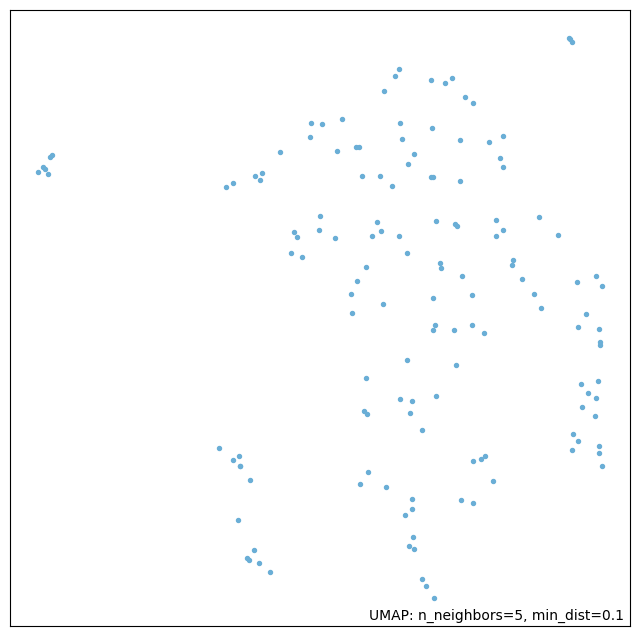

In [35]:
embeddings_cls_pca = pca.fit_transform(embeddings_cls)
embedding = umap.UMAP(n_neighbors=5).fit(embeddings_cls_pca)
umap.plot.points(embedding)

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_scp/lib/python3.10/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

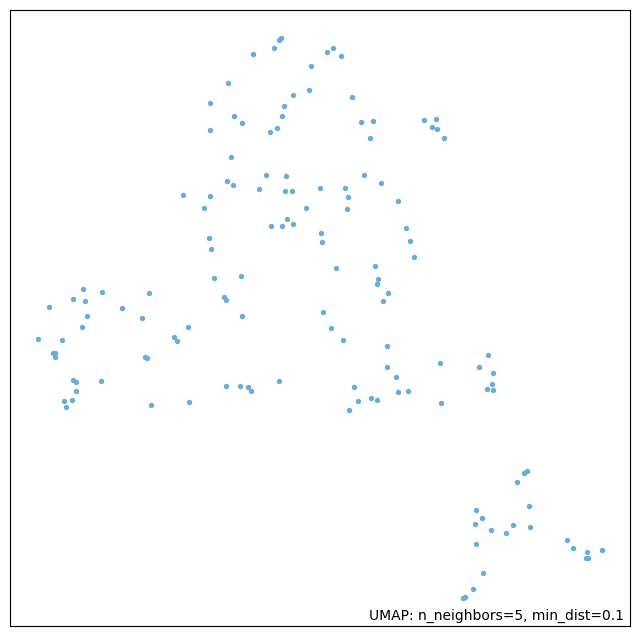

In [36]:
embeddings_mean_pca = pca.fit_transform(embeddings_mean)
embedding = umap.UMAP(n_neighbors=5).fit(embeddings_mean_pca)
umap.plot.points(embedding)

In [37]:
pca.explained_variance_ratio_

array([0.17516744, 0.16631981, 0.08598431, 0.04858799, 0.03695107,
       0.03537204, 0.02688338, 0.02438725, 0.0204954 , 0.01972992,
       0.01928628, 0.01686256, 0.01673535, 0.01528863, 0.01380646,
       0.01330296, 0.01186924, 0.01143547, 0.01095395, 0.01047066,
       0.00965515, 0.00935036, 0.00873085, 0.00812376, 0.0079632 ,
       0.00757921, 0.00725931, 0.00699774, 0.00680844, 0.00642063])

In [38]:
df_embedding = pd.DataFrame(embeddings_mean_pca, columns=['ChemBERTa_' + str(i) for i in range(30)])
df_embedding['sm_name'] = df_compound['sm_name'].values
df_embedding['SMILES'] = df_compound['SMILES'].values

In [39]:
df_embedding.head()

,ChemBERTa_0,ChemBERTa_1,ChemBERTa_2,ChemBERTa_3,ChemBERTa_4,ChemBERTa_5,ChemBERTa_6,ChemBERTa_7,ChemBERTa_8,ChemBERTa_9,...,ChemBERTa_22,ChemBERTa_23,ChemBERTa_24,ChemBERTa_25,ChemBERTa_26,ChemBERTa_27,ChemBERTa_28,ChemBERTa_29,sm_name,SMILES
0,1.400530,-0.852967,-0.582822,-0.809206,-0.051650,-0.673735,-0.543063,-0.660368,0.011960,0.141631,...,0.018228,0.553002,-0.175593,-0.205938,0.328213,0.289953,0.234009,0.165885,Clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
1,-0.247881,-0.686762,2.044995,0.078853,0.865587,-0.765618,0.861688,0.086517,-0.369891,1.574609,...,0.302191,0.119016,-0.175393,0.700034,-0.119779,0.639626,-0.500860,-0.085684,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...
2,0.670710,1.404434,-0.350441,0.681979,0.513530,-0.035814,0.481072,-0.070070,0.734374,0.036481,...,0.149629,0.552633,0.380843,-0.258679,-0.051670,0.087329,0.028335,0.122858,Idelalisib,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...
3,0.129725,3.352361,-0.134575,-0.368495,-0.298542,-0.087963,0.307502,0.352310,0.078964,0.040327,...,0.203761,-0.079327,0.146406,-0.680816,-0.070553,-0.308131,-0.536454,-0.168424,Vandetanib,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
4,-1.494508,0.461034,0.683080,-1.333416,-1.421309,0.386542,0.504409,0.444664,-0.396418,0.183564,...,0.144295,-0.267623,-0.411353,-0.441758,0.199405,-0.368794,-0.197889,-0.037703,Bosutinib,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...


In [41]:
df_embedding.to_csv('../../results/ChemBERTa-77M-MTR/df_embedding.csv')